In [1]:
using Pkg, Revise
Pkg.activate(".")

In [290]:
using DeconvOptim, Plots, Noise, FourierTools, FFTW, PGFPlotsX

┌ Info: Precompiling PGFPlotsX [8314cec4-20b6-5062-9cdb-752b83310925]
└ @ Base loading.jl:1317


In [539]:
x = -2.5:0.01:12.5#range#(-3, 13, length=1000)
x_psf = 0:0.01:15#range(0, 16, length=1000)
x_psf2 = -7.5:0.01:7.5
x_measured = collect(0:0.01:10)[1:end-1]#range(0, 10, length=1000)


f(x) = begin 
        if x < -10
            return f(0)
        elseif x > 20
            return f(10)
        else
            r = x
            for i in 1:7
                r += 1 / i * sin(2^i * x)
            end
            return r
        end
            #sin(x) + x + sin(2*x) + sin(4*x) + sin(8 * x) + sin(16*x) + sin(32*x) + sin(64*x)
    end

ground_truth = f.(x);
ground_truth_short = ground_truth[251:1250]


psf_f(x) = exp(-10 * x)* (100*x)^2
psf_f2(x) = exp(-100*x^2)


psf_long = psf_f2.(x_psf2);
psf_long ./= sum(psf_long);


measured_long = add_gauss(FourierTools.conv(ground_truth, ifftshift(psf_long)), 1);
measured = measured_long[251:1250];
psf = ifftshift(center_extract(psf_long, (1000,)));
psf ./= sum(psf);

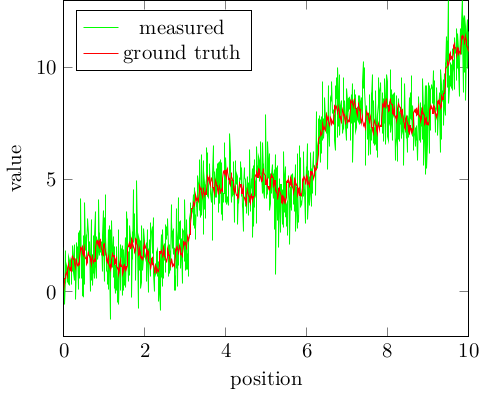

In [540]:
plt1 = @pgf Axis(
    {xlabel="position", ylabel="value", xmin=0, xmax=10, ymin=-2, ymax=13, legend_pos="north west", legend_entries={"measured", "ground truth"}},

    Plot({"sharp plot", color="green"
        },
        Table([x_measured, measured])
    ),
    Plot({"sharp plot", color="red"
        },
        Table([x_measured, ground_truth_short])
    ),
)
pgfsave("1d_plot_data_blurred.pdf", plt1)
plt1


In [486]:
function fft_abs(x)
    x_ft = abs.(ffts(x))
    x_ft ./= maximum(x_ft)
    return x_ft
end

otf = fft_abs(psf)

ground_truth_fft = fft_abs(ground_truth_short)
measured_ft = fft_abs(measured)

freqs = fftshift(fftfreq(length(psf)))

res_ft = fft_abs(res_pad);

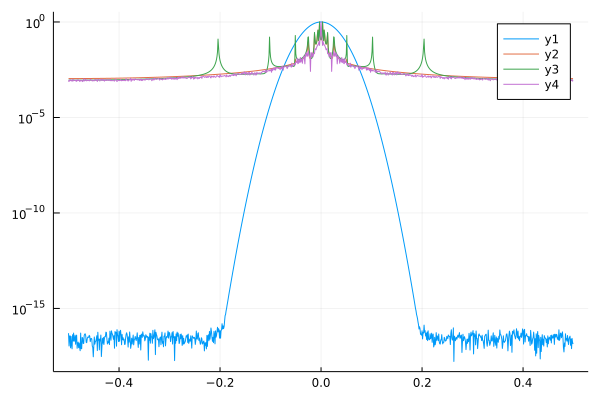

In [500]:
plot(freqs, otf, yaxis=:log)
plot!(freqs, measured_ft)
plot!(freqs, ground_truth_fft, yaxis=:log)
plot!(freqs, res_ft)

In [365]:
reg = DeconvOptim.TV(num_dims=1)

#216 (generic function with 1 method)

In [558]:
@time res, o = deconvolution(measured, psf, loss=Gauss(), iterations=12, regularizer=reg, λ=0.05);
o

  0.001293 seconds (3.31 k allocations: 1.913 MiB)


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     6.170392e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.30e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.09e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.39e-02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.25e-03 ≰ 0.0e+00
    |g(x)|                 = 2.18e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    12
    f(x) calls:    15
    ∇f(x) calls:   13


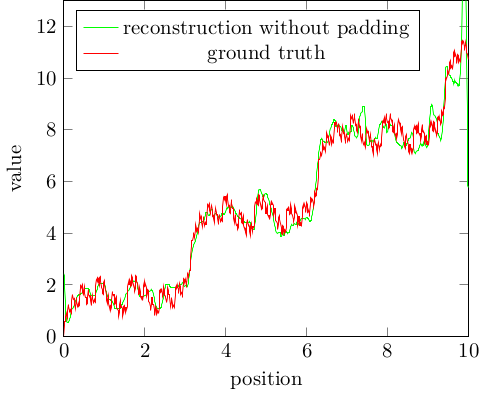

In [574]:
plt1 = @pgf Axis(
    {xlabel="position", ylabel="value", xmin=0, xmax=10, ymin=0, ymax=13, legend_pos="north west", legend_entries={"reconstruction without padding", "ground truth"}},

    Plot({"sharp plot", color="green"
        },
        Table([x_measured, res])
    ),
    Plot({"sharp plot", color="red"
        },
        Table([x_measured, ground_truth_short])
    ),
)
pgfsave("1d_plot_data_res_without_pad.pdf", plt1)
plt1

In [566]:
@time res_pad, o = deconvolution(measured, psf, loss=Gauss(), iterations=12, regularizer=reg, λ=0.05,
                                 padding=1);

  0.002775 seconds (3.87 k allocations: 4.606 MiB)


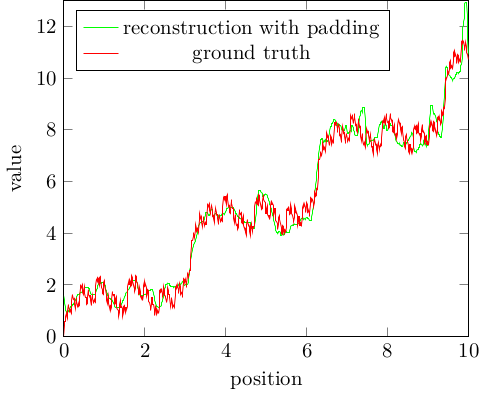

In [573]:
plt1 = @pgf Axis(
    {xlabel="position", ylabel="value", xmin=0, xmax=10, ymin=0, ymax=13, legend_pos="north west", legend_entries={"reconstruction_with_padding", "ground truth"}},

    Plot({"sharp plot", color="green"
        },
        Table([x_measured, res_pad])
    ),
    Plot({"sharp plot", color="red"
        },
        Table([x_measured, ground_truth_short])
    ),
)
pgfsave("1d_plot_data_res_pad.pdf", plt1)
plt1